### Generate instrument data for Specsim eBOSS configuration 

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import bossdata
import os
import fitsio
import speclite.filters

import astropy.units as u
import pandas as pd

from astropy.io import fits
from astropy.table import Table, vstack

##### Refer to http://bossdata.readthedocs.io/en/latest/index.html to learn more about the bossdata package.

In [3]:
print(bossdata.__version__)

finder = bossdata.path.Finder()
mirror = bossdata.remote.Manager()

0.3.2dev


In [4]:
desimodel_path = '/Users/belaabolfathi/desi/code/desimodel/data/'
specsim_path = '/Users/belaabolfathi/desi/code/specsim/specsim/data/sdss/'

### Access spCFrame files to get data for specpsf:

* Wavelength
* Row width/pixel size
* Wavelength dispersion/FWHM resolution
* Spatial resolution/n_eff

In [5]:
def get_cframe_hdulist(plate, mjd, band, fiber, sequence_number=0):
    
    """Prepare plan path to access spCFrame data for a specific spectrograph camera.
    
    The spCFrame files contain the flux-calibrated spectra for a single CCD.
    For more information see: https://data.sdss.org/datamodel/files/BOSS_SPECTRO_REDUX/RUN2D/PLATE4/spCFrame.html.
    
    Parameters
    ----------
    
    plate: int
        Plate number for the observation.
    mjd: int
        MJD for the observation.
    band: str
        Specifies which camera to use. Must be 'blue' or 'red'.
    fiber: int
        Fiber number indicating which spectrograph to use. Must be in the range 1-1000.
    sequence_number: int
        Science exposure sequence number, counting from zero.
        
    
    Returns
    -------
    
    :class: `astropy.io.fits.HDUList`
        FITS data files associated with individual exposures.
    """

    plan_path = finder.get_plate_plan_path(plate=plate, mjd=mjd, combined=True)
    local_plan_path = local_plan_path = mirror.get(plan_path)
    Plan = bossdata.plate.Plan(local_plan_path)
    exp_name = Plan.get_exposure_name(sequence_number=sequence_number, band=band, fiber=fiber, ftype='spCFrame')
    local_fits = mirror.get(os.path.join(plan_path.strip(os.path.basename(plan_path)), exp_name))
    
    return(fits.open(local_fits))

def get_all_cframe_data(plate, mjd, sequence_number=0):
    
    '''Access cFrame data for each one of the four spectrograph cameras.
    
    Parameters
    ----------
    
    plate: int
        Plate number for the observation.
    mjd: int
        MJD for the observation.
    sequence_number: int
        Science exposure sequence number, counting from zero.
        
        
    Returns
    -------
    
    :class: `astropy.io.fits.HDUList`
        FITS data files associated with individual exposures for all four spectrograph cameras.
    '''
    
    b1_hdulist = get_cframe_hdulist(plate=plate, mjd=mjd, band='blue', fiber=30, sequence_number=sequence_number)
    b2_hdulist = get_cframe_hdulist(plate=plate, mjd=mjd, band='blue', fiber=600, sequence_number=sequence_number)
    r1_hdulist = get_cframe_hdulist(plate=plate, mjd=mjd, band='red', fiber=30, sequence_number=sequence_number)
    r2_hdulist = get_cframe_hdulist(plate=plate, mjd=mjd, band='red', fiber=600, sequence_number=sequence_number)
    
    return b1_hdulist, b2_hdulist, r1_hdulist, r2_hdulist


def get_neff(plate, mjd):
    
    """Get profile width data for all fibers for a given PLATE, MJD, and for all
    four spectrograph cameras.
    
    Parameters
    ----------
    
    
    Returns
    -------
    
    """
    
    remote_plate_spec_path = finder.get_plate_spec_path(plate=plate, mjd=mjd)
    plate_spec_path = mirror.get(remote_plate_spec_path)
    PlateFile = bossdata.plate.PlateFile(plate_spec_path)    
    
    exp_nameb1 = PlateFile.exposures.get_exposure_name(exposure_index=1, camera='b1', 
                                                     ftype='spFlat')
    exp_nameb2 = PlateFile.exposures.get_exposure_name(exposure_index=1, camera='b2', 
                                                     ftype='spFlat')
    exp_namer1 = PlateFile.exposures.get_exposure_name(exposure_index=1, camera='r1', 
                                                     ftype='spFlat')
    exp_namer2 = PlateFile.exposures.get_exposure_name(exposure_index=1, camera='r2', 
                                                     ftype='spFlat')

    remote_plate_path_b1 = finder.get_plate_path(plate=plate, filename=exp_nameb1)
    remote_plate_path_b2 = finder.get_plate_path(plate=plate, filename=exp_nameb2)
    remote_plate_path_r1 = finder.get_plate_path(plate=plate, filename=exp_namer1)
    remote_plate_path_r2 = finder.get_plate_path(plate=plate, filename=exp_namer2)
    
    plate_path_b1 = mirror.get(remote_plate_path_b1)
    plate_path_b2 = mirror.get(remote_plate_path_b2)
    plate_path_r1 = mirror.get(remote_plate_path_r1)
    plate_path_r2 = mirror.get(remote_plate_path_r2)

    hdulist_b1 = fitsio.FITS(plate_path_b1, mode=fitsio.READONLY)
    hdulist_b2 = fitsio.FITS(plate_path_b2, mode=fitsio.READONLY)
    hdulist_r1 = fitsio.FITS(plate_path_r1, mode=fitsio.READONLY)
    hdulist_r2 = fitsio.FITS(plate_path_r2, mode=fitsio.READONLY)
    
    TraceSet_b1 = bossdata.plate.TraceSet(hdulist_b1[3])
    TraceSet_b2 = bossdata.plate.TraceSet(hdulist_b2[3])
    TraceSet_r1 = bossdata.plate.TraceSet(hdulist_r1[3])
    TraceSet_r2 = bossdata.plate.TraceSet(hdulist_r2[3])

    return TraceSet_b1, TraceSet_b2, TraceSet_r1, TraceSet_r2

def combine(plate, mjd, fwhm=True):
    
    """Combine all specpsf data for a given PLATE, MJD.
    
    Parameters
    ----------
    
    plate: list or np.array
        Plate numbers for the observations.
    mjd: list or np.array
        MJDs for the observations.
    fwhm: 
        Specify whether to calculate rms or fwhm resolution.
    
    Returns
    -------
    
    The wavelength, resolution, row width and spatial resolution data for all fibers on all four spectrograph 
    cameras on the specified plates. All have shape (len(plate),500,4128), except for the blue camera spatial
    resolution array, which has shape (len(plate,500,4112)).
    
    """
    
    fwhm = np.sqrt(8*np.log(2))
    coef = 2*np.sqrt(np.pi)
    
        
    # Profile width data (note: length is different for blue and red cameras)
    b1neff = np.empty((len(plate), 500, 4112), dtype=float)
    b2neff = np.empty((len(plate), 500, 4112), dtype=float)
    r1neff = np.empty((len(plate), 500, 4128), dtype=float)
    r2neff = np.empty((len(plate), 500, 4128), dtype=float)        

    # Wavelength data
    b1wlen = np.empty((len(plate), 500, 4128), dtype=float)
    b2wlen = np.empty((len(plate), 500, 4128), dtype=float)
    r1wlen = np.empty((len(plate), 500, 4128), dtype=float)
    r2wlen = np.empty((len(plate), 500, 4128), dtype=float)

    # Wavelength dispersion data
    b1res = np.empty((len(plate), 500, 4128), dtype=float)
    b2res = np.empty((len(plate), 500, 4128), dtype=float)
    r1res = np.empty((len(plate), 500, 4128), dtype=float)
    r2res = np.empty((len(plate), 500, 4128), dtype=float)

    # Row width data
    b1width = np.empty((len(plate), 500, 4128), dtype=float)
    b2width = np.empty((len(plate), 500, 4128), dtype=float)
    r1width = np.empty((len(plate), 500, 4128), dtype=float)
    r2width = np.empty((len(plate), 500, 4128), dtype=float)
        
    
    
    for i in range(len(plate)):
        
        b1TraceSet, b2TraceSet, r1TraceSet, r2TraceSet = get_neff(plate=plate[i], mjd=mjd[i])

        b1neff[i] = b1TraceSet.get_y()
        b2neff[i] = b2TraceSet.get_y()
        r1neff[i] = r1TraceSet.get_y()
        r2neff[i] = r2TraceSet.get_y()
            
        b1, b2, r1, r2 = get_all_cframe_data(plate=plate[i], mjd=mjd[i])
        
        b1wlen[i] = 10**b1[3].data
        b2wlen[i] = 10**b2[3].data
        r1wlen[i] = 10**r1[3].data
        r2wlen[i] = 10**r2[3].data
        
        b1width[i] = np.gradient(b1wlen[i], axis=1)
        b2width[i] = np.gradient(b2wlen[i], axis=1)
        r1width[i] = np.gradient(r1wlen[i], axis=1)
        r2width[i] = np.gradient(r2wlen[i], axis=1)

        b1res[i] = b1[4].data*0.0001*np.log(10)*b1wlen[i]
        b2res[i] = b2[4].data*0.0001*np.log(10)*b2wlen[i]
        r1res[i] = r1[4].data*0.0001*np.log(10)*r1wlen[i]
        r2res[i] = r2[4].data*0.0001*np.log(10)*r2wlen[i]
                
        if fwhm:
        
            b1res[i] = b1res[i]*fwhm
            b2res[i] = b2res[i]*fwhm
            r1res[i] = r1res[i]*fwhm
            r2res[i] = r2res[i]*fwhm
                
                
    return(b1wlen, b2wlen, r1wlen, r2wlen, b1res, b2res, r1res, r2res, 
           b1width, b2width, r1width, r2width, coef*b1neff, coef*b2neff, coef*r1neff, coef*r2neff)


def define_canon_grid(bwlen, rwlen, n_out, lo_trim=None, hi_trim=None):
    
    """Define a canonical wavelength grid based on the minimum and maximum wavlength range 
    of all fibers on a plate.
    
    Parameters
    ----------
    
    bwlen: numpy.ndarray
        An ndarray of shape (len(plate),1000,4128) of all fibers on b1 and b2 cameras. 
    rwlen: numpy.ndarray
        An ndarray of shape (len(plate),1000,4128) of all 1000 fibers on r1 and r2 cameras.
    n_out: int
        The number of samples to generate for the canonical grid.
    lo_trim: int
        Lower index at which to trim the data. 
    hi_trim: int
        Upper index at which to trim the data. 
    
    Returns
    -------
    
    Numpy arrays for the blue and red canonical wavelength grids.
    
    """
    
    b_canon = np.linspace(np.max(bwlen[:,:,0]), np.min(bwlen[:,:,-1]), n_out)
    r_canon = np.linspace(np.max(rwlen[:,:,0]), np.min(rwlen[:,:,-1]), n_out)
    
    if lo_trim:
        b_canon = b_canon[lo_trim:]
        r_canon = r_canon[lo_trim:]
        
    if hi_trim:
        b_canon = b_canon[:hi_trim]
        r_canon = r_canon[:hi_trim]
    
    return(b_canon, r_canon)

def summarize(b_grid, r_grid, b_wlen, r_wlen, b_data, r_data, summary=np.median):
    
    """Interpolate data over canonical grid and return the median over all fibers
    on all plates.
    
    Parameters
    ----------
    
    b_grid: np.array
        The blue canonical wavelength grid.
    r_grid: 
        The red canonical wavelength grid.
    bwlen: numpy.ndarray
        An ndarray of shape (len(plate),1000,4128) of all fibers on b1 and b2 cameras. 
    rwlen: numpy.ndarray
        An ndarray of shape (len(plate),1000,4128) of all 1000 fibers on r1 and r2 cameras.
    b_data: 
        An ndarray of blue camera data of shape (len(plate),1000,4128), except for the blue spatial 
        resolution array, which has shape (len(plate,500,4112)), to be interpolated over the blue canonical grid.
    r_data: 
        An ndarray of red camera data of shape (len(plate),1000,4128) to be interpolated over the red canonical grid.
    summary: 
        Statistic to use to calculate a single output for the camera data. 
    Returns
    -------
    
    Numpy arrays of the camera data interpolated over the canonical grids. 
    
    """
    
    assert b_wlen.shape == b_data.shape
    assert r_wlen.shape == r_data.shape
    
    n_out = len(b_canon) # red and blue have different lengths
    num_plates = b_data.shape[0]
        
    b_interp = np.empty((num_plates, 1000, n_out), dtype=float)
    r_interp = np.empty((num_plates, 1000, n_out), dtype=float)
    
    for plate in range(num_plates):
        for fiber in range(1000):
            b_interp[plate, fiber] = np.interp(x=b_grid, xp=b_wlen[plate][fiber], fp=b_data[plate][fiber])
            r_interp[plate, fiber] = np.interp(x=r_grid, xp=r_wlen[plate][fiber], fp=r_data[plate][fiber])
    
    return(summary(b_interp, axis=(0,1)), summary(r_interp, axis=(0,1)))

In [6]:
plate = [7027, 6963, 7301, 6759, 6002, 6178, 6626, 6882, 7389, 7453, 
         7517, 6472, 6660, 6877, 6970, 6122, 7456, 7377, 7454, 7564]
        
mjd = [56448, 56724, 56746, 56416, 56104, 56213, 56330, 56541, 56769, 
       56749, 56772, 56362, 56370, 56544, 56444, 56246, 56727, 56741, 56751, 56804]

### Generate config data using 20 different plate-mjds

In [7]:
# Get data for all plate-mjds
b1wlen, b2wlen, r1wlen, r2wlen, b1res, b2res, r1res, r2res, b1width, b2width, r1width, r2width, b1neff, b2neff, r1neff, r2neff = combine(plate, mjd, fwhm=True)

# Combine data for blue and red cameras
bwlen = np.concatenate((b1wlen, b2wlen), axis=1)
rwlen = np.concatenate((r1wlen, r2wlen), axis=1)
bres = np.concatenate((b1res, b2res), axis=1)
rres = np.concatenate((r1res, r2res), axis=1)
bwidth = np.concatenate((b1width, b2width), axis=1)
rwidth = np.concatenate((r1width, r2width), axis=1)
bneff = np.concatenate((b1neff, b2neff), axis=1)
rneff = np.concatenate((r1neff, r2neff), axis=1)

# Create canonical wavelength grid
n_out = bneff.shape[2]
b_canon, r_canon = define_canon_grid(bwlen, rwlen, n_out, lo_trim=60, hi_trim=-80)

# Take the median
bres_int, rres_int = summarize(b_canon, r_canon, bwlen, rwlen, bres, rres)
bwid_int, rwid_int = summarize(b_canon, r_canon, bwlen, rwlen, bwidth, rwidth)
bneff_int, rneff_int = summarize(b_canon, r_canon, bwlen[:,:,:n_out], rwlen, bneff, rneff)

### Compare to DESI instrument

In [8]:
desi_hdulist = fitsio.FITS(desimodel_path + 'specpsf/psf-quicksim.fits', mode=fitsio.READONLY)

quicksim_b, quicksim_r, quicksim_z = desi_hdulist[1].read(), desi_hdulist[2].read(), desi_hdulist[3].read()

desi_bwlen = quicksim_b['wavelength']
desi_rwlen = quicksim_r['wavelength']
desi_zwlen = quicksim_z['wavelength']

desi_bres = quicksim_b['fwhm_wave']
desi_rres = quicksim_r['fwhm_wave']
desi_zres = quicksim_z['fwhm_wave']

desi_bwidth = quicksim_b['angstroms_per_row']
desi_rwidth = quicksim_r['angstroms_per_row']
desi_zwidth = quicksim_z['angstroms_per_row']

desi_bneff = quicksim_b['fwhm_spatial']
desi_rneff = quicksim_r['fwhm_spatial']
desi_zneff = quicksim_z['fwhm_spatial']

### Canonical wavelength grid

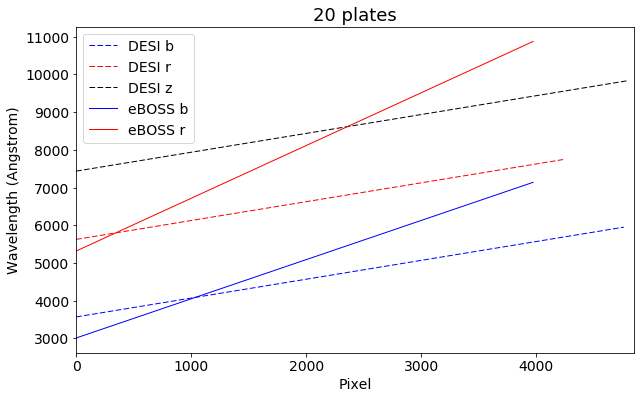

In [9]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(0,len(desi_bwlen)), desi_bwlen, '--b', lw=1, label='DESI b')
plt.plot(np.arange(0,len(desi_rwlen)), desi_rwlen, '--r', lw=1, label='DESI r')
plt.plot(np.arange(0,len(desi_zwlen)), desi_zwlen, '--k', lw=1, label='DESI z')
plt.plot(b_canon, 'b', label='eBOSS b', lw=1)
plt.plot(r_canon, 'r', label='eBOSS r', lw=1)
plt.xlabel('Pixel', fontsize=14)
plt.ylabel('Wavelength (Angstrom)', fontsize=14)
plt.title('20 plates', fontsize=18)
plt.xlim(0,4850)
plt.legend(loc=2, fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

### Wavelength dispersion
#### eBOSS

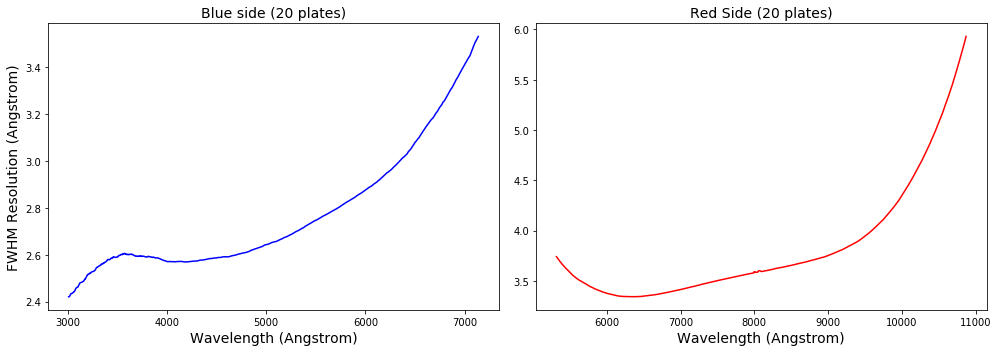

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))

ax1.plot(b_canon, bres_int, 'b')
ax2.plot(r_canon, rres_int, 'r')

ax1.set_title('Blue side (20 plates)', fontsize=14)
ax1.set_xlabel('Wavelength (Angstrom)', fontsize=14)
ax1.set_ylabel('FWHM Resolution (Angstrom)', fontsize=14)
ax2.set_title('Red Side (20 plates)', fontsize=14)
ax2.set_xlabel('Wavelength (Angstrom)', fontsize=14)
plt.tight_layout()
plt.show()

#### DESI

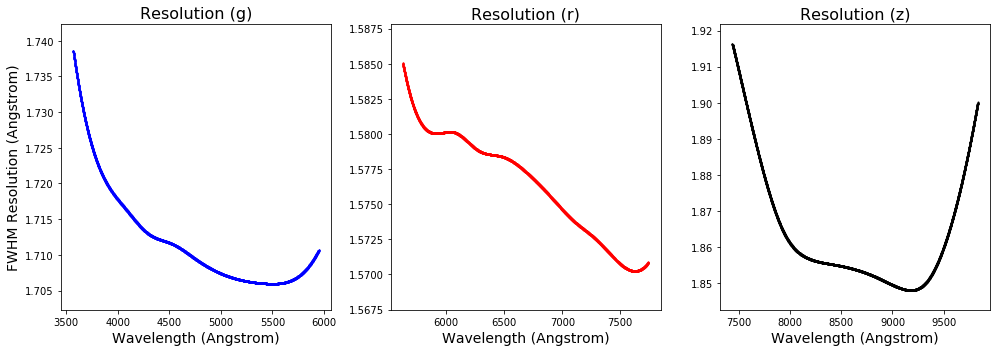

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(14,5))


ax1.scatter(desi_bwlen, desi_bres, s=1, c='b')
ax2.scatter(desi_rwlen, desi_rres, s=1, c='r')
ax3.scatter(desi_zwlen, desi_zres, s=1, c='k')

ax1.set_title('Resolution (g)', fontsize=16)
ax1.set_xlabel('Wavelength (Angstrom)', fontsize=14)
ax1.set_ylabel('FWHM Resolution (Angstrom)', fontsize=14)
ax2.set_title('Resolution (r)', fontsize=16)
ax2.set_xlabel('Wavelength (Angstrom)', fontsize=14)
ax3.set_title('Resolution (z)', fontsize=16)
ax3.set_xlabel('Wavelength (Angstrom)', fontsize=14)

plt.tight_layout()
plt.show()

### Row width 
#### eBOSS

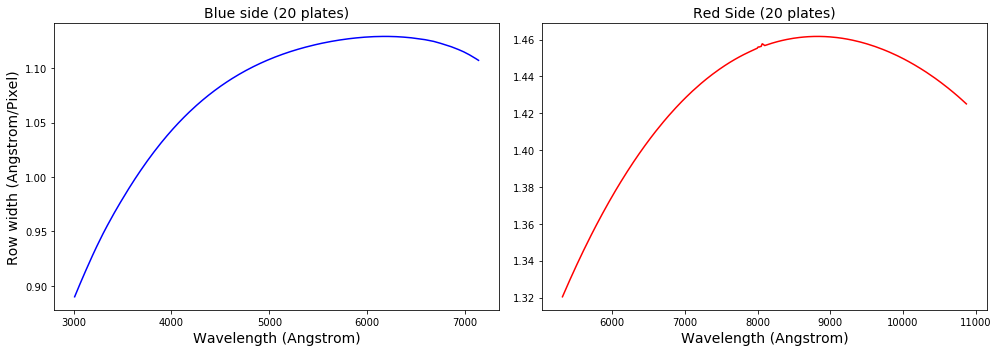

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))

ax1.plot(b_canon, bwid_int, 'b')
ax2.plot(r_canon, rwid_int, 'r')

ax1.set_title('Blue side (20 plates)', fontsize=14)
ax1.set_xlabel('Wavelength (Angstrom)', fontsize=14)
ax1.set_ylabel('Row width (Angstrom/Pixel)', fontsize=14)
ax2.set_title('Red Side (20 plates)', fontsize=14)
ax2.set_xlabel('Wavelength (Angstrom)', fontsize=14)
plt.tight_layout()
plt.show()

#### DESI

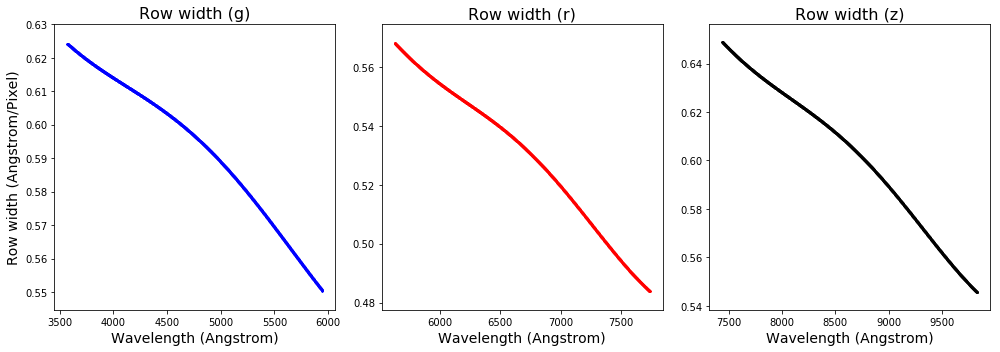

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(14,5))


ax1.scatter(desi_bwlen, desi_bwidth, s=1, c='b')
ax2.scatter(desi_rwlen, desi_rwidth, s=1, c='r')
ax3.scatter(desi_zwlen, desi_zwidth, s=1, c='k')

ax1.set_title('Row width (g)', fontsize=16)
ax1.set_xlabel('Wavelength (Angstrom)', fontsize=14)
ax1.set_ylabel('Row width (Angstrom/Pixel)', fontsize=14)
ax2.set_title('Row width (r)', fontsize=16)
ax2.set_xlabel('Wavelength (Angstrom)', fontsize=14)
ax3.set_title('Row width (z)', fontsize=16)
ax3.set_xlabel('Wavelength (Angstrom)', fontsize=14)

plt.tight_layout()
plt.show()

### Spatial resolution

#### eBOSS

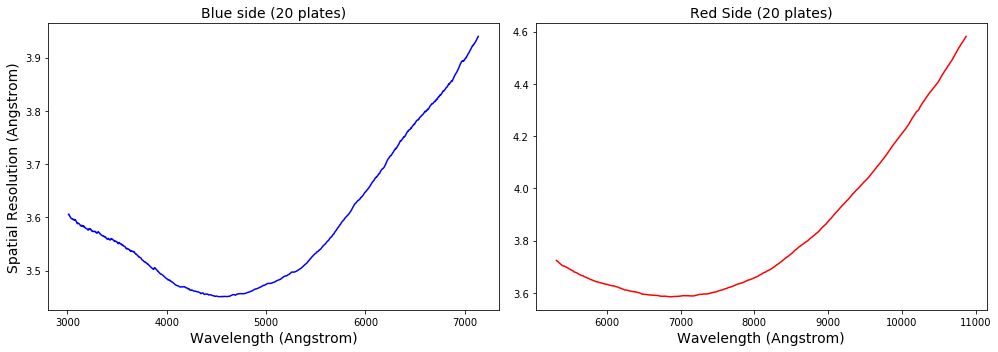

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))

ax1.plot(b_canon, bneff_int, 'b')
ax2.plot(r_canon, rneff_int, 'r')

ax1.set_title('Blue side (20 plates)', fontsize=14)
ax1.set_xlabel('Wavelength (Angstrom)', fontsize=14)
ax1.set_ylabel('Spatial Resolution (Angstrom)', fontsize=14)
ax2.set_title('Red Side (20 plates)', fontsize=14)
ax2.set_xlabel('Wavelength (Angstrom)', fontsize=14)
plt.tight_layout()
plt.show()

#### DESI

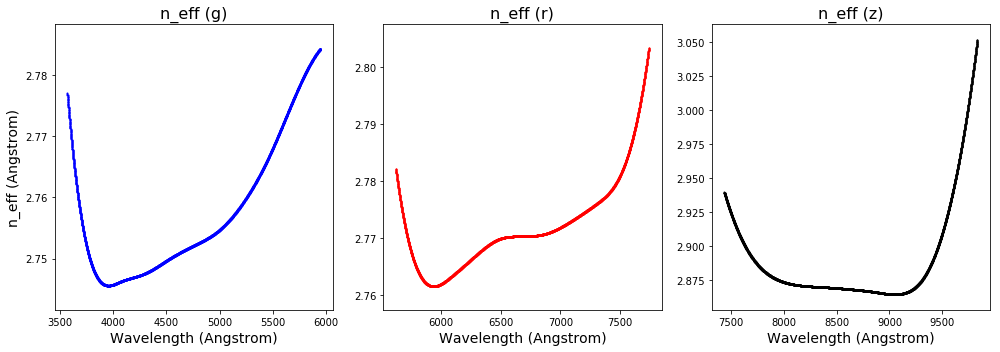

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(14,5))


ax1.scatter(desi_bwlen, desi_bneff, s=1, c='b')
ax2.scatter(desi_rwlen, desi_rneff, s=1, c='r')
ax3.scatter(desi_zwlen, desi_zneff, s=1, c='k')

ax1.set_title('n_eff (g)', fontsize=16)
ax1.set_xlabel('Wavelength (Angstrom)', fontsize=14)
ax1.set_ylabel('n_eff (Angstrom)', fontsize=14)
ax2.set_title('n_eff (r)', fontsize=16)
ax2.set_xlabel('Wavelength (Angstrom)', fontsize=14)
ax3.set_title('n_eff (z)', fontsize=16)
ax3.set_xlabel('Wavelength (Angstrom)', fontsize=14)

plt.tight_layout()
plt.show()

### Write specpsf data

In [169]:
blue = Table([b_canon*u.Angstrom, bres_int*u.Angstrom, bwid_int*u.Angstrom/u.pix, 
              bneff_int*u.pix], names=('wavelength', 'fwhm_wave', 'angstroms_per_row', 
                                                          'neff_spatial'))
red = Table([r_canon*u.Angstrom, rres_int*u.Angstrom, rwid_int*u.Angstrom/u.pix, 
             rneff_int*u.pix], names=('wavelength', 'fwhm_wave', 'angstroms_per_row', 
                                                          'neff_spatial'))

blue.write(specsim_path + 'eboss-blue.fits', overwrite=True)
red.write(specsim_path + 'eboss-red.fits', overwrite=True)

### Adjust additional config data to be within the interpolation range

In [133]:
def fit_and_pad(data, col1, col2, ni=None, nf=None, col1_min=2980, col1_max=10100, fit_order=1):
    
    ## Fits a polynomial of order fit_order if ni/nf are specified, otherwise just pads with lowest/highest value
        
    assert(data[col1][0] > col1_min)
    assert(data[col1][-1] < col1_max)
    
    dwlen = np.diff(data[col1])[100] # Choose an index in the middle since diff=0 at the beg/end for b/r cameras
    col1_beg = np.arange(col1_min, data[col1][0], dwlen)
    col1_end = np.arange(data[col1][-1], col1_max, dwlen)
    
    if ni:
        col1_beg = np.arange(col1_min, data[col1][ni[0]], dwlen)
        func_beg = np.poly1d(np.polyfit(data[col1][ni[0]:ni[1]], data[col2][ni[0]:ni[1]], fit_order))
        col2_beg = func_beg(col1_beg)
    else:
        col2_beg = np.full(len(col1_beg), data[col2][0])
        
    if nf:
        col1_end = np.arange(data[col1][nf[1]], col1_max, dwlen)
        func_end = np.poly1d(np.polyfit(data[col1][nf[0]:nf[1]], data[col2][nf[0]:nf[1]], fit_order))
        col2_end = func_end(col1_end)
    else:
        col2_end = np.full(len(col1_end), data[col2][-1])
    
    pad_beg = Table([col1_beg, col2_beg], names=(col1, col2))
    pad_end = Table([col1_end, col2_end], names=(col1, col2))
    new_data = vstack([pad_beg, data])
    new_data = vstack([new_data, pad_end])

    return(new_data)

### Adjust sky data

In [11]:
desi_sky = Table.read(desimodel_path + 'spectra/spec-sky.dat', format='ascii')
eboss_sky = fit_and_pad(desi_sky, 'WAVELENGTH', 'FLUX')
eboss_sky.write(specsim_path + 'eboss-spec-sky.dat', format='ascii', overwrite=True)

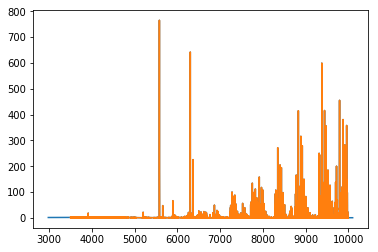

In [12]:
plt.plot(eboss_sky['WAVELENGTH'], eboss_sky['FLUX'])
plt.plot(desi_sky['WAVELENGTH'], desi_sky['FLUX'])
plt.show()

### Adjust extinction data

In [13]:
extinction = Table.read('/Users/belaabolfathi/Data/desimodel/0.4.2/data/spectra/ZenithExtinction-KPNO.dat', format='ascii')
eboss_extinction = fit_and_pad(extinction, 'WAVELENGTH', 'EXTINCTION', ni=[0,3000], fit_order=2)
eboss_extinction.write(specsim_path + 'eboss-KPNO-extinction.dat', format='ascii', overwrite=True)

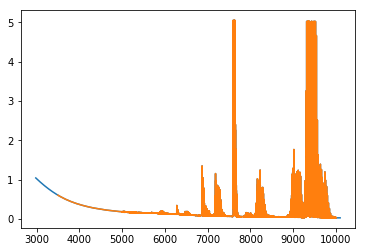

In [14]:
plt.plot(eboss_extinction['WAVELENGTH'], eboss_extinction['EXTINCTION'])
plt.plot(extinction['WAVELENGTH'], extinction['EXTINCTION'])
plt.show()

### Adjust throughput data

Using data from Smee et al. paper (see Fig. 28 of https://arxiv.org/abs/1208.2233)

In [15]:
boss_throughput_curves = pd.read_excel(specsim_path + 'throughputs_for_BOSS_paper_revA.xlsx',  sheetname='BOSS')

In [16]:
other_losses = 0.85 * 0.96 * 0.83

throughput_wlen = boss_throughput_curves['Wavelength']
blue_thru = boss_throughput_curves['Telescope'] * boss_throughput_curves['Collimator'] * boss_throughput_curves['Dichroic R'] * boss_throughput_curves['Blue grism'] * boss_throughput_curves['Blue camera'] * boss_throughput_curves['e2v CCD'] * other_losses
red_thru = boss_throughput_curves['Telescope'] * boss_throughput_curves['Collimator'] * boss_throughput_curves['Dichroic T'] * boss_throughput_curves['Red grism'] * boss_throughput_curves['Red camera'] * boss_throughput_curves['LBL CCD'] * other_losses

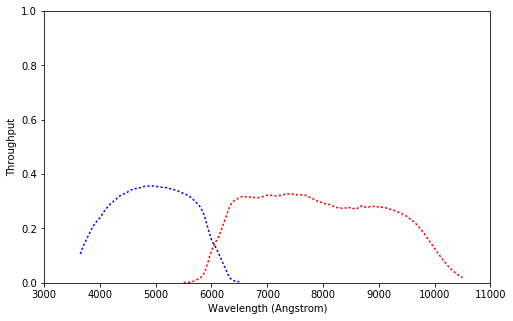

In [17]:
plt.figure(figsize=(8,5))
plt.plot(throughput_wlen * 10, blue_thru, c='b', ls=':')
plt.plot(throughput_wlen * 10, red_thru, c='r', ls=':')
plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('Throughput')
plt.xlim(3000,11000)
plt.ylim(0,1)
plt.show()

In [49]:
eboss_thru_b = Table([throughput_wlen * 10, blue_thru], names=('wavelength', 'throughput'))
eboss_thru_r = Table([throughput_wlen * 10, red_thru], names=('wavelength', 'throughput'))

In [143]:
## Don't want nan values in the throughput table
eboss_thru_b[:65] = eboss_thru_b[65]
eboss_thru_r[-50:] = eboss_thru_r[-51]

In [146]:
max_b_wlen = eboss_thru_b['wavelength'][-1] + 1
max_r_wlen = eboss_thru_r['wavelength'][-1] + 1
new_eboss_thru_b = fit_and_pad(eboss_thru_b, 'wavelength', 'throughput', col1_max=max_b_wlen)
new_eboss_thru_r = fit_and_pad(eboss_thru_r, 'wavelength', 'throughput', col1_max=max_r_wlen)

new_eboss_thru_b.write(specsim_path + 'eboss-thru-b.fits', overwrite=True)
new_eboss_thru_r.write(specsim_path + 'eboss-thru-r.fits', overwrite=True)

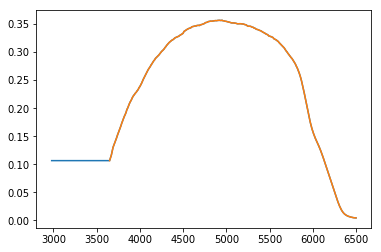

In [137]:
plt.plot(new_eboss_thru_b['wavelength'], new_eboss_thru_b['throughput'])
plt.plot(eboss_thru_b['wavelength'], eboss_thru_b['throughput'])
plt.show()

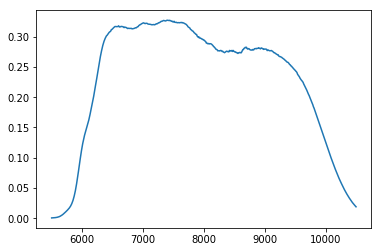

In [140]:
plt.plot(new_eboss_thru_r['wavelength'], new_eboss_thru_r['throughput'])
plt.plot(eboss_thru_r['wavelength'], eboss_thru_r['throughput'])
plt.show()

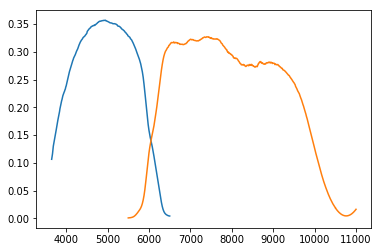

In [23]:
plt.plot(new_eboss_thru_b['wavelength'], new_eboss_thru_b['throughput'])
plt.plot(new_eboss_thru_r['wavelength'], new_eboss_thru_r['throughput'])
plt.show()

### Source

In [29]:
qso = Table.read('/Users/belaabolfathi/desi/code/desimodel/data/spectra/spec-qso-z1.5-rmag22.24.dat', format='ascii')
new_qso = fit_and_pad(qso, 'WAVELENGTH', 'FLUX', ni=[0,50], nf=[-100,-1], fit_order=1)
new_qso.write(specsim_path + 'spec-qso.dat', format='ascii', overwrite=True)

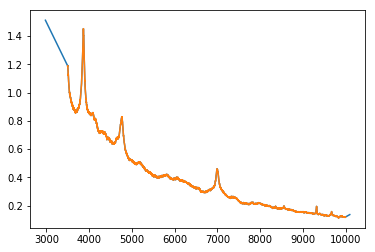

In [30]:
plt.plot(new_qso['WAVELENGTH'], new_qso['FLUX'])
plt.plot(qso['WAVELENGTH'], qso['FLUX'])